
NKE Attack
==============================




In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [ ]:
def attack(image, epsilon, data_grad, attack_type='fgsm'):
    opt = {'fgsm':1, 'nke':-1}

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + opt[attack_type] * epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def testAttack( model, device, test_loader, epsilon,num_steps=1, attack_type='fgsm'):

    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    L_inf = []
    L_2 = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        total += 1

        num_steps = 1
        for i in range(num_steps):
          loss = F.cross_entropy(output, target)        
          loss.backward()
          data_grad = data.grad.data
          perturbed_data = attack(data, epsilon, data_grad, attack_type)
          data.data = perturbed_data
          model.zero_grad()
          output = model(data)

          # compute L_inf distance
        a = np.abs((perturbed_data.detach().cpu()[0,0] - data.detach().cpu()[0,0]).flatten())  
        tmp = LA.norm(a, np.inf)
        tmp2 = LA.norm(a)
        L_inf.append(tmp)
        # L_0.append(tmp0)
        L_2.append(tmp2)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/total #float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, L_inf, L_2

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 10, kernel_size=1)
        self.conv1 = nn.Conv2d(10, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x0 = F.relu(self.conv0(x))
        x = F.relu(F.max_pool2d(self.conv1(x0), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x #F.log_softmax(x, dim=1), x0
    
# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    

In [ ]:
ls /gdrive/MyDrive/ClassificationImages/models

cifar_net.pth  lenet_mnist_model.pth  mnist_cnn.pth


In [ ]:
from torchsummary import summary


model = Net().to(device)  # training with slope 1 for now
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              20
            Conv2d-2           [-1, 10, 24, 24]           2,510
            Conv2d-3             [-1, 20, 8, 8]           5,020
         Dropout2d-4             [-1, 20, 8, 8]               0
            Linear-5                   [-1, 50]          16,050
            Linear-6                   [-1, 10]             510
Total params: 24,110
Trainable params: 24,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.09
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


### Train a model if you dont have one

In [ ]:
EPOCHS = 10
losses = []

coeff = 10e-3

# del optimizer
optimizer = optim.Adadelta(model.parameters(), lr=(1e-2))


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 
        # import pdb; pdb.set_trace()
        # L0_reg = torch.norm(x0,0)/x0.numel() # fraction of non zero elements
                                   
        # Calculate loss
        
        loss = F.cross_entropy(y_pred, target)
        # loss = (1-coeff) * F.nll_loss(y_pred, target) + coeff * L0_reg       
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
    evaluate_y = test_loader.dataset.targets

    evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        


    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))
    

    

 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 1.319278	 Test Accuracy: 87.2500%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.256012	 Test Accuracy: 91.2600%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.210109	 Test Accuracy: 92.5100%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.285029	 Test Accuracy: 92.7500%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.192327	 Test Accuracy: 93.6000%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.135772	 Test Accuracy: 94.0800%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.135612	 Test Accuracy: 94.3500%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.049690	 Test Accuracy: 94.9100%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.163464	 Test Accuracy: 95.0500%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.150458	 Test Accuracy: 95.3500%


In [ ]:
# !ls /gdrive/MyDrive/ClassificationImages/NewTypeExamples
pathh = '/gdrive/MyDrive/ClassificationImages/NewTypeExamples' 

In [ ]:
torch.save(model.state_dict(), pathh+'\model.pth')

In [ ]:
evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(90.7300, dtype=torch.float64)


# Now perform adversarial attack

In [ ]:
# # MNIST Test dataset and dataloader declaration
test_loader_new = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=False)

epsilons = [0, .01, .04, .07, .1, .4, .5, .6] #, .9, .93, .96, .99, 1]
model.eval()

# Run test for each epsilon
accuracies = []
examples = []
infs = []
L2s = []


for eps in epsilons:
    acc, ex, m_L_inf, m_L_2 = testAttack(model, device, test_loader_new, eps, num_steps=2, attack_type='fgsm')
    accuracies.append(acc)
    examples.append(ex)
    infs.append(np.mean(m_L_inf)/256)
    L2s.append(np.mean(m_L_2)/256)
    # print(f'{eps}, {infs[-1]}, {L2s[-1]}: {acc}')



Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9293 / 9585 = 0.9695357329160146
Epsilon: 0.04	Test Accuracy = 7257 / 9585 = 0.7571205007824726
Epsilon: 0.07	Test Accuracy = 3123 / 9585 = 0.32582159624413143
Epsilon: 0.1	Test Accuracy = 797 / 9585 = 0.08315075639019301
Epsilon: 0.4	Test Accuracy = 0 / 9585 = 0.0
Epsilon: 0.5	Test Accuracy = 0 / 9585 = 0.0
Epsilon: 0.6	Test Accuracy = 0 / 9585 = 0.0


#plots

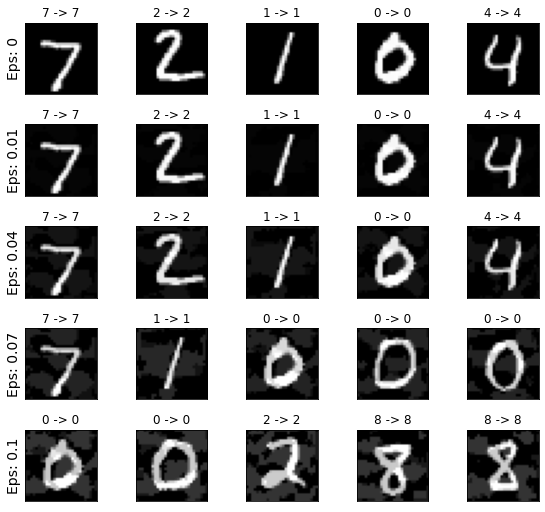

In [ ]:
# Plot several examples of adversarial samples at each epsilon

epsilons = epsilons[:7]

cnt = 0
# plt.figure(figsize=(8,20))
plt.figure(figsize=(8,10))
# for i in range(len(epsilons)):
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
def parse_data(res):
  indexes = [x.start() for x in re.finditer(' = ', res)]

  RES = []
  for i in indexes[1::2]:
    if res[i+3:i+6] in ['0.0', '1.0']:
      RES.append(float(res[i+2:i+7]))
    else:
      RES.append(float(res[i+2:i+8]))

  return RES


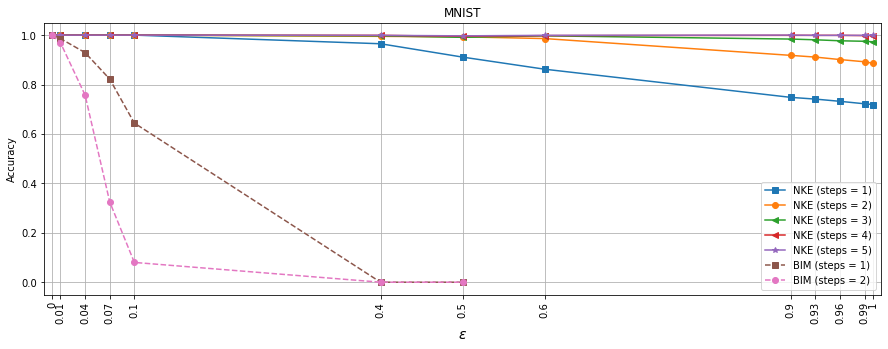

In [ ]:
import re

fgsm_res1 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9451 / 9585 = 0.9860198226395409
Epsilon: 0.04	Test Accuracy = 8912 / 9585 = 0.9297861241523213
Epsilon: 0.07	Test Accuracy = 7884 / 9585 = 0.8225352112676056
Epsilon: 0.1	Test Accuracy = 6180 / 9585 = 0.6447574334898278
Epsilon: 0.4	Test Accuracy = 1 / 9585 = 0.00010432968179447053
Epsilon: 0.5	Test Accuracy = 0 / 9585 = 0.0"""

fgsm_res2 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9293 / 9585 = 0.9695357329160146
Epsilon: 0.04	Test Accuracy = 7257 / 9585 = 0.7571205007824726
Epsilon: 0.07	Test Accuracy = 3123 / 9585 = 0.32582159624413143
Epsilon: 0.1	Test Accuracy = 797 / 9585 = 0.08315075639019301
Epsilon: 0.4	Test Accuracy = 0 / 9585 = 0.0
Epsilon: 0.5	Test Accuracy = 0 / 9585 = 0.0"""



net_res1 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9258 / 9585 = 0.9658841940532081
Epsilon: 0.5	Test Accuracy = 8734 / 9585 = 0.9112154407929056
Epsilon: 0.6	Test Accuracy = 8268 / 9585 = 0.8625978090766823
Epsilon: 0.9	Test Accuracy = 7178 / 9585 = 0.7488784559207095
Epsilon: 0.93	Test Accuracy = 7103 / 9585 = 0.7410537297861242
Epsilon: 0.96	Test Accuracy = 7017 / 9585 = 0.7320813771517997
Epsilon: 0.99	Test Accuracy = 6922 / 9585 = 0.722170057381325
Epsilon: 1	Test Accuracy = 6899 / 9585 = 0.7197704747000522"""


net_res2 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9543 / 9585 = 0.9956181533646322
Epsilon: 0.5	Test Accuracy = 9520 / 9585 = 0.9932185706833594
Epsilon: 0.6	Test Accuracy = 9453 / 9585 = 0.9862284820031298
Epsilon: 0.9	Test Accuracy = 8805 / 9585 = 0.918622848200313
Epsilon: 0.93	Test Accuracy = 8740 / 9585 = 0.9118414188836724
Epsilon: 0.96	Test Accuracy = 8642 / 9585 = 0.9016171100678143
Epsilon: 0.99	Test Accuracy = 8559 / 9585 = 0.8929577464788733
Epsilon: 1	Test Accuracy = 8500 / 9585 = 0.8868022952529995"""


net_res3 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9564 / 9585 = 0.9978090766823161
Epsilon: 0.5	Test Accuracy = 9502 / 9585 = 0.991340636411059
Epsilon: 0.6	Test Accuracy = 9557 / 9585 = 0.9970787689097548
Epsilon: 0.9	Test Accuracy = 9432 / 9585 = 0.984037558685446
Epsilon: 0.93	Test Accuracy = 9406 / 9585 = 0.9813249869587898
Epsilon: 0.96	Test Accuracy = 9370 / 9585 = 0.9775691184141888
Epsilon: 0.99	Test Accuracy = 9348 / 9585 = 0.9752738654147105
Epsilon: 1	Test Accuracy = 9330 / 9585 = 0.97339593114241"""

net_res4 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9583 / 9585 = 0.9997913406364111
Epsilon: 0.5	Test Accuracy = 9544 / 9585 = 0.9957224830464267
Epsilon: 0.6	Test Accuracy = 9568 / 9585 = 0.998226395409494
Epsilon: 0.9	Test Accuracy = 9581 / 9585 = 0.9995826812728221
Epsilon: 0.93	Test Accuracy = 9579 / 9585 = 0.9993740219092332
Epsilon: 0.96	Test Accuracy = 9579 / 9585 = 0.9993740219092332
Epsilon: 0.99	Test Accuracy = 9575 / 9585 = 0.9989567031820553
Epsilon: 1	Test Accuracy = 9574 / 9585 = 0.9988523735002608"""

# step 5
net_res5 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9581 / 9585 = 0.9995826812728221
Epsilon: 0.5	Test Accuracy = 9562 / 9585 = 0.9976004173187272
Epsilon: 0.6	Test Accuracy = 9584 / 9585 = 0.9998956703182055
Epsilon: 0.9	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.93	Test Accuracy = 9584 / 9585 = 0.9998956703182055
Epsilon: 0.96	Test Accuracy = 9584 / 9585 = 0.9998956703182055
Epsilon: 0.99	Test Accuracy = 9584 / 9585 = 0.9998956703182055
Epsilon: 1	Test Accuracy = 9585 / 9585 = 1.0"""




gauss_res = """Epsilon: 0.0	Test Accuracy = 9797 / 9797 = 1.0
Epsilon: 6.416666666666667	Test Accuracy = 9791 / 9797 = 0.9993875676227416
Epsilon: 12.833333333333334	Test Accuracy = 9786 / 9797 = 0.9988772073083597
Epsilon: 19.25	Test Accuracy = 9776 / 9797 = 0.9978564866795958
Epsilon: 25.666666666666668	Test Accuracy = 9774 / 9797 = 0.997652342553843
Epsilon: 32.083333333333336	Test Accuracy = 9761 / 9797 = 0.9963254057364499
Epsilon: 38.5	Test Accuracy = 9745 / 9797 = 0.9946922527304277
Epsilon: 44.91666666666667	Test Accuracy = 9718 / 9797 = 0.9919363070327651
Epsilon: 51.333333333333336	Test Accuracy = 9715 / 9797 = 0.991630090844136
Epsilon: 57.75	Test Accuracy = 9692 / 9797 = 0.9892824333979789
Epsilon: 64.16666666666667	Test Accuracy = 9679 / 9797 = 0.9879554965805859
Epsilon: 70.58333333333334	Test Accuracy = 9642 / 9797 = 0.9841788302541594
Epsilon: 77.0	Test Accuracy = 9619 / 9797 = 0.9818311728080025
Epsilon: 100	Test Accuracy = 9450 / 9797 = 0.9645809941818925
Epsilon: 200	Test Accuracy = 7646 / 9797 = 0.7804429927528835
Epsilon: 500	Test Accuracy = 2892 / 9797 = 0.295192405838522
Epsilon: 1000	Test Accuracy = 1597 / 9797 = 0.163009084413596
Epsilon: 2000	Test Accuracy = 1209 / 9797 = 0.12340512401755639"""





epsilons = [0, .01, .04, .07, .1, .4, .5, .6, .9, .93, .96, .99, 1]
plt.figure(figsize=(15,5))
plt.plot(epsilons, parse_data(net_res1), "s-")
plt.plot(epsilons, parse_data(net_res2), "o-")
plt.plot(epsilons, parse_data(net_res3), "<-")
plt.plot(epsilons, parse_data(net_res4), "<-")
plt.plot(epsilons, parse_data(net_res5), "*-")
plt.plot(epsilons[:7], parse_data(fgsm_res1), "s--")
plt.plot(epsilons[:7], parse_data(fgsm_res2), "o--")

# plt.plot(np.log10(infs),GAUSS_res, 's-')
# plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(epsilons, [str(e) for e in epsilons], rotation=90)
plt.title("MNIST")
plt.xlabel("$\epsilon$", fontsize=14)
plt.ylabel("Accuracy")
plt.xlim(-0.01,1.01)
plt.grid(True)
plt.legend(['NKE (steps = 1)', 'NKE (steps = 2)', 'NKE (steps = 3)', 'NKE (steps = 4)', 'NKE (steps = 5)', 'BIM (steps = 1)', 'BIM (steps = 2)'])
plt.show()

# np.linspace(0,77,13).tolist()+[100,200,500,1000,2000]